In [1]:
from luxai_s2.env import LuxAI_S2
from luxai_s2.map.board import Board
# from luxai_s2.state import State
from luxai_s2.map_generator.generator import GameMap
# from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
import logging
import numpy as np
# from lux.kit import obs_to_game_state, GameState, EnvConfig
# from luxai_s2.utils import animate
# from lux.utils import direction_to, 
from luxai_s2.utils import my_turn_to_place_factory


# import cv2
# import os
# import string
# import random
from agents_experiments import (reset_w_custom_board, IdleAgent, interact)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")
matplotlib.rc('font', size=14)



# needed for class below
from luxai_s2.env import EnvConfig
    
class ControlledAgent:
    factories: dict
    actions: dict
    calls_to_act: int = 0
    
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg
            
    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            return dict(faction="AlphaStrike", bid=0)
        else:
            myteam = obs['teams'][self.player]

            # how much water and metal you have in your starting pool to give to new factories
            try:
                water_left = myteam['water']
            except AttributeError:
                print(myteam)
                raise 
            metal_left = myteam['metal']

            # how many factories you have left to place
            factories_to_place = myteam['factories_to_place']
            
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(myteam['place_first'], step)
            
            if factories_to_place > 0 and my_turn_to_place:
                inner_list = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                potential_spawns = np.array(inner_list)
#                 logging.info(f'ControlledAgent {potential_spawns.shape=}')
                
#                 wish = {i: {(i, x) for x in range(39, 48)} for i in range(39, 48)}
#                 for i in range(39, 48):
#                     logging.info(f"{wish[i].intersection(inner_list)=}")
                
                selected_location_ix = 0
                spawn_loc = potential_spawns[selected_location_ix]
#                 logging.info(f'ControlledAgent {spawn_loc=}')
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()


    def act(self, step: int, obs, remainingOverageTime: int = 60):
        self.calls_to_act += 1
        actions = dict()
        game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        self.factories = factories
        logger.info(f"{type(factories)=}")
        logger.info(f"{factories=}")
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
        self.actions = actions
        return actions
    
    def debug_act(self, step: int, obs, remainingOverageTime: int = 60):
        
        # who am I?
        logger.info(f'I am {self.player}')
        
        # what turn is it?
        logger.info(f'{step=}  {remainingOverageTime=}')
        
        self.calls_to_act += 1
        actions = dict()
        
        # how many factories does each player have, and where?
        def count_and_locate_factories(fac):
            count = len(fac)
            locations = list(v.pos for v in fac.values())
            return count, locations
#         print(obs)
#         raise ValueError("STOPPING ON PURPOSE")
        myteam = obs['teams'][self.player]
        opp_team = obs['teams'][self.opp_player]
        try:
            my_factories = count_and_locate_factories(myteam['factories'])
            logger.info(f'{my_factories=}')
        except KeyError:
            logger.info('no factories found in controlled agent\'s team')
            
        try:
            opponents_factories =count_and_locate_factories(opp_team['factories'])
            logger.info(f'{opponents_factories=}')
        except KeyError:
            logger.info('no factories found in opponent agent\'s team')
            
        
        # where are ice and ore?
        logger.info('where are ice and ore?')
        
        factories = obs['factories'][self.player]
        self.factories = factories
        
        logger.info(f"{type(factories)=}")
        logger.info(f"{factories=}")
        for unit_id, factory in factories.items():
            if factory['power'] >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory['cargo']['metal'] >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                try:
                    actions[unit_id] = 1  # build heavy
                except AttributeError:
                    print(obs)
                    raise
        self.actions = actions
        
        # what were my returned actions?
        logger.info(f'{actions=}')
        return actions

In [2]:
# key-values of dict below should match attributes present in this class
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/config.py#L34
environment_config = dict(
        max_episode_length=350,  # how many total turns in game
        CYCLE_LENGTH=50,
        DAY_LENGTH=50,  # so no night
        MAX_RUBBLE=0,  # disable rubble   
        MIN_FACTORIES=2,  
        MAX_FACTORIES=2
    )
env = LuxAI_S2(**environment_config)
custom_rubble = np.zeros((env.env_cfg.map_size,) * 2, dtype=np.int64)

# Let's put a single ice at 30,30
custom_ice = np.zeros_like(custom_rubble)
custom_ice[30, 30] = 1

# Let's put a single ore at 21, 21
custom_ore = np.zeros_like(custom_rubble)
custom_ore[21, 21] = 1

custom_symmetry = None


custom_map_ = GameMap(custom_rubble, custom_ice, custom_ore, custom_symmetry)

simple_board = Board(
    seed=env.seed_rng.randint(0, 2**32 - 1, dtype=np.int64), 
    env_cfg=env.env_cfg,
    existing_map=custom_map_
)

obs, env = reset_w_custom_board(env, seed=41, custom_board=simple_board)
    
# source code of reset() method: 
# https://github.com/aernesto/Lux-Design-S2/blob/adrian/luxai_s2/luxai_s2/env.py#L175
# obs = env.reset(seed=41) # resets an environment with a seed

In [3]:
# first player cannot place factory on any boundary, so inner square has dimensions 46x46
# the 2 isolated resources remove each 9 tiles from the potential spawn locations
46*46- 9*2

2098

In [4]:
2098 -28

2070

In [5]:
# recreate our agents and run
agents = {}
for player, agent_constructor in zip(env.agents, [IdleAgent, ControlledAgent]):
    logging.debug(player)
    agents[player] = agent_constructor(player, env.state.env_cfg) 
last_obs = interact(env, agents, 3, animate_=False, custom_board=simple_board)
last_obs

{'player_0': {'units': {'player_0': {}, 'player_1': {}},
  'teams': {'player_0': {'team_id': 0,
    'faction': 'AlphaStrike',
    'water': 150,
    'metal': 150,
    'factories_to_place': 1,
    'factory_strains': [0],
    'place_first': True,
    'bid': 0},
   'player_1': {'team_id': 1,
    'faction': 'AlphaStrike',
    'water': 150,
    'metal': 150,
    'factories_to_place': 1,
    'factory_strains': [1],
    'place_first': False,
    'bid': 0}},
  'factories': {'player_0': {'factory_0': {'pos': array([46, 46]),
     'power': 1000,
     'cargo': {'ice': 0, 'ore': 0, 'water': 150, 'metal': 150},
     'unit_id': 'factory_0',
     'strain_id': 0,
     'team_id': 0}},
   'player_1': {'factory_1': {'pos': array([1, 1]),
     'power': 1000,
     'cargo': {'ice': 0, 'ore': 0, 'water': 150, 'metal': 150},
     'unit_id': 'factory_1',
     'strain_id': 1,
     'team_id': 1}}},
  'board': {'rubble': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0,

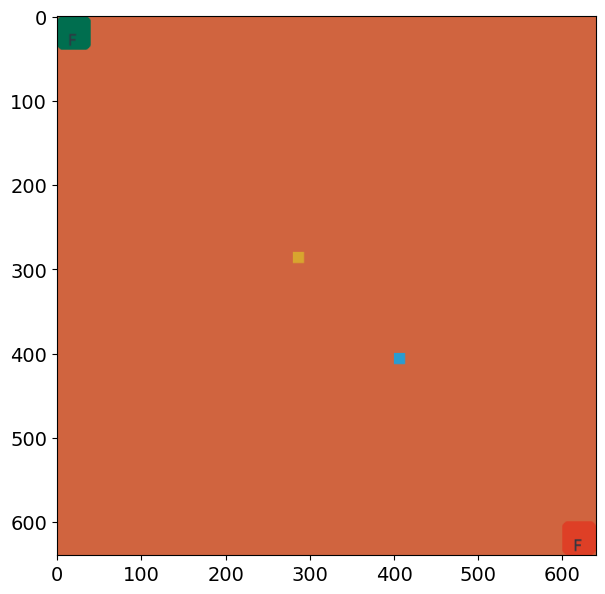

In [6]:
#video above is missing bottom pixels for some reason 
img = env.render("rgb_array", width=640, height=640)
f, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img);

In [7]:
for player, agent_constructor in zip(env.agents, [IdleAgent, ControlledAgent]):
    logging.debug(player)
    agents[player] = agent_constructor(player, env.state.env_cfg) 
last_obs = interact(
    env, agents, 15, animate_=False, break_at_first_action=True, debug=True, custom_board=simple_board
)
print(last_obs)

INFO:root:step=1
INFO:root:step=2
INFO:root:step=3
INFO:root:step=4
INFO:root:step=5
INFO:root:step=5  inner_counter=0
INFO:root:I am player_1
INFO:root:step=5  remainingOverageTime=60
INFO:root:no factories found in controlled agent's team
INFO:root:no factories found in opponent agent's team
INFO:root:where are ice and ore?
INFO:root:type(factories)=<class 'dict'>
INFO:root:factories={'factory_1': {'pos': array([1, 8]), 'power': 1000, 'cargo': {'ice': 0, 'ore': 0, 'water': 150, 'metal': 150}, 'unit_id': 'factory_1', 'strain_id': 1, 'team_id': 1}, 'factory_3': {'pos': array([ 1, 15]), 'power': 1000, 'cargo': {'ice': 0, 'ore': 0, 'water': 150, 'metal': 150}, 'unit_id': 'factory_3', 'strain_id': 3, 'team_id': 1}}
INFO:root:actions={'factory_1': 1, 'factory_3': 1}
INFO:root:step=5  inner_counter=0
INFO:root:step=6  inner_counter=1
INFO:root:I am player_1
INFO:root:step=6  remainingOverageTime=60
INFO:root:no factories found in controlled agent's team
INFO:root:no factories found in oppon

{'player_0': {'units': {'player_0': {}, 'player_1': {'unit_4': {'team_id': 1, 'unit_id': 'unit_4', 'power': 520, 'unit_type': 'HEAVY', 'pos': array([1, 8]), 'cargo': {'ice': 0, 'ore': 0, 'water': 0, 'metal': 0}, 'action_queue': []}, 'unit_5': {'team_id': 1, 'unit_id': 'unit_5', 'power': 520, 'unit_type': 'HEAVY', 'pos': array([ 1, 15]), 'cargo': {'ice': 0, 'ore': 0, 'water': 0, 'metal': 0}, 'action_queue': []}}}, 'teams': {'player_0': {'team_id': 0, 'faction': 'AlphaStrike', 'water': 0, 'metal': 0, 'factories_to_place': 0, 'factory_strains': [0, 2], 'place_first': True, 'bid': 0}, 'player_1': {'team_id': 1, 'faction': 'AlphaStrike', 'water': 0, 'metal': 0, 'factories_to_place': 0, 'factory_strains': [1, 3], 'place_first': False, 'bid': 0}}, 'factories': {'player_0': {'factory_0': {'pos': array([46, 39]), 'power': 1100, 'cargo': {'ice': 0, 'ore': 0, 'water': 148, 'metal': 150}, 'unit_id': 'factory_0', 'strain_id': 0, 'team_id': 0}, 'factory_2': {'pos': array([46, 32]), 'power': 1100, 'c

In [8]:
agents['player_1'].factories

{'factory_1': {'pos': array([1, 8]),
  'power': 550,
  'cargo': {'ice': 0, 'ore': 0, 'water': 149, 'metal': 50},
  'unit_id': 'factory_1',
  'strain_id': 1,
  'team_id': 1},
 'factory_3': {'pos': array([ 1, 15]),
  'power': 550,
  'cargo': {'ice': 0, 'ore': 0, 'water': 149, 'metal': 50},
  'unit_id': 'factory_3',
  'strain_id': 3,
  'team_id': 1}}

In [9]:
agents['player_1'].actions

{}

In [10]:
agents['player_1'].calls_to_act

2

Inspect last_obs

In [11]:
def parse_deep_dict(d):
    copy = {}
    for k, v in d.items():
        if isinstance(v, dict):
            copy[k] = parse_deep_dict(v)
        else:
            copy[k] = type(v)
            
    return copy

In [12]:
a = {
    1: {'a': 'b'},
    2: [3, 4],
    3: {5: {89: 'lskjdf', 'lskjf': 'alphabet'}, 4: [392423, 2]}
}

In [13]:
pprint(parse_deep_dict(a))

Pretty printing has been turned OFF


In [14]:
from pprint import pprint

In [15]:
parsed = parse_deep_dict(last_obs)
pprint(parsed)

{'player_0': {'board': {'factories_per_team': <class 'int'>,
                        'ice': <class 'numpy.ndarray'>,
                        'lichen': <class 'numpy.ndarray'>,
                        'lichen_strains': <class 'numpy.ndarray'>,
                        'ore': <class 'numpy.ndarray'>,
                        'rubble': <class 'numpy.ndarray'>,
                        'valid_spawns_mask': <class 'numpy.ndarray'>},
              'factories': {'player_0': {'factory_0': {'cargo': {'ice': <class 'int'>,
                                                                 'metal': <class 'int'>,
                                                                 'ore': <class 'int'>,
                                                                 'water': <class 'int'>},
                                                       'pos': <class 'numpy.ndarray'>,
                                                       'power': <class 'int'>,
                                                    